# **Melanoma Detection Model - Data exploration**
## Advanced Machine Learning a.y. 23-24

This project was done by:


*   Danilo Corsi (matr. 1742375)
*   Alessio Lucciola (matr. 1823638)
*   Domiziano Scarcelli (matr. 1872664)

# 1. Introduction

This project aims to develop a melanoma detection model using the HAM10k dataset from Harvard Dataverse, comprising dermatoscopic images of pigmented skin lesions. 
Unlike existing binary classification approaches, our focus is on multi-class classification, identifying both malignancy and the specific type of skin lesion. Leveraging CNNs, we seek to explore alternative methods such as Vision Transformers to enhance overall accuracy.
The dataset presents challenges, notably high imbalance and potential bias due to non-mole skin parts. To address imbalances, we augment the training set with randomly rotated and flipped images. Additionally, the availability of lesion segmentations allows us to develop a segmentation model, aiding in identifying and isolating moles during inference for improved performance. We have experimented with different segmentation methods to strike a balance between accuracy and speed.
Our primary objective is to maximize recall on the test set while maintaining high accuracy, crucial for early and accurate melanoma detection.

# 2. Import Libraries

In [1]:
# Python imports
from typing import Optional, Tuple
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import random

# Project imports
from config import METADATA_TRAIN_DIR
from shared.constants import IMAGENET_STATISTICS
from shared.enums import SegmentationStrategy, DynamicSegmentationStrategy

# Utils imports
from utils.plot_utils import plot_image_grid
from utils.dataloader_utils import get_dataloder_from_strategy

Using device: cuda
Using device: cuda


# 3. Data exploration

In this section we are going to explore the content inside of the `data` folder which will be used:
-   `HAM10000_images_train`: the directory containing the images which will be split into train, validation and test set
-   `HAM10000_segmentations_lesion_tschandl`: the directory containing the masks for the train images
-   `HAM10000_metadata_train.csv`: the .csv file containing the metadata for the images (labels and other info) which will be split into train, validation and test set

## 3.1 Metadata visualization (original)

In [2]:
# Load metadata
df = pd.read_csv(METADATA_TRAIN_DIR)
print(pd.DataFrame(df.dtypes, columns=['Type']))
df

                 Type
lesion_id      object
image_id       object
dx             object
dx_type        object
age           float64
sex            object
localization   object
dataset        object


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


Let's explain briefly some of the 'features' contained in the metadata:
- `lesion_id`: skin lesion id in the metadata
- `image_id`: image id referring to the lesion_id in the dataset
- `dx`: describe the type of skin lesion detected.
- `dx_type`: indicates the detection method used.
- `localization`: indicates the body position of the skin lesion.
- `dataset`: indicates the dataset source (this is a dataset composed of several datasets put together)

In [3]:
# Shapes of dataset
print(df.shape)

(10015, 8)


In [4]:
# Count the number of duplicates for each column
df.duplicated().sum()

0

In [5]:
# Get all Nan values the dataset
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64

There are some null values in this dataset, but since our problem is more image-related, we do not consider this to be a problem. 

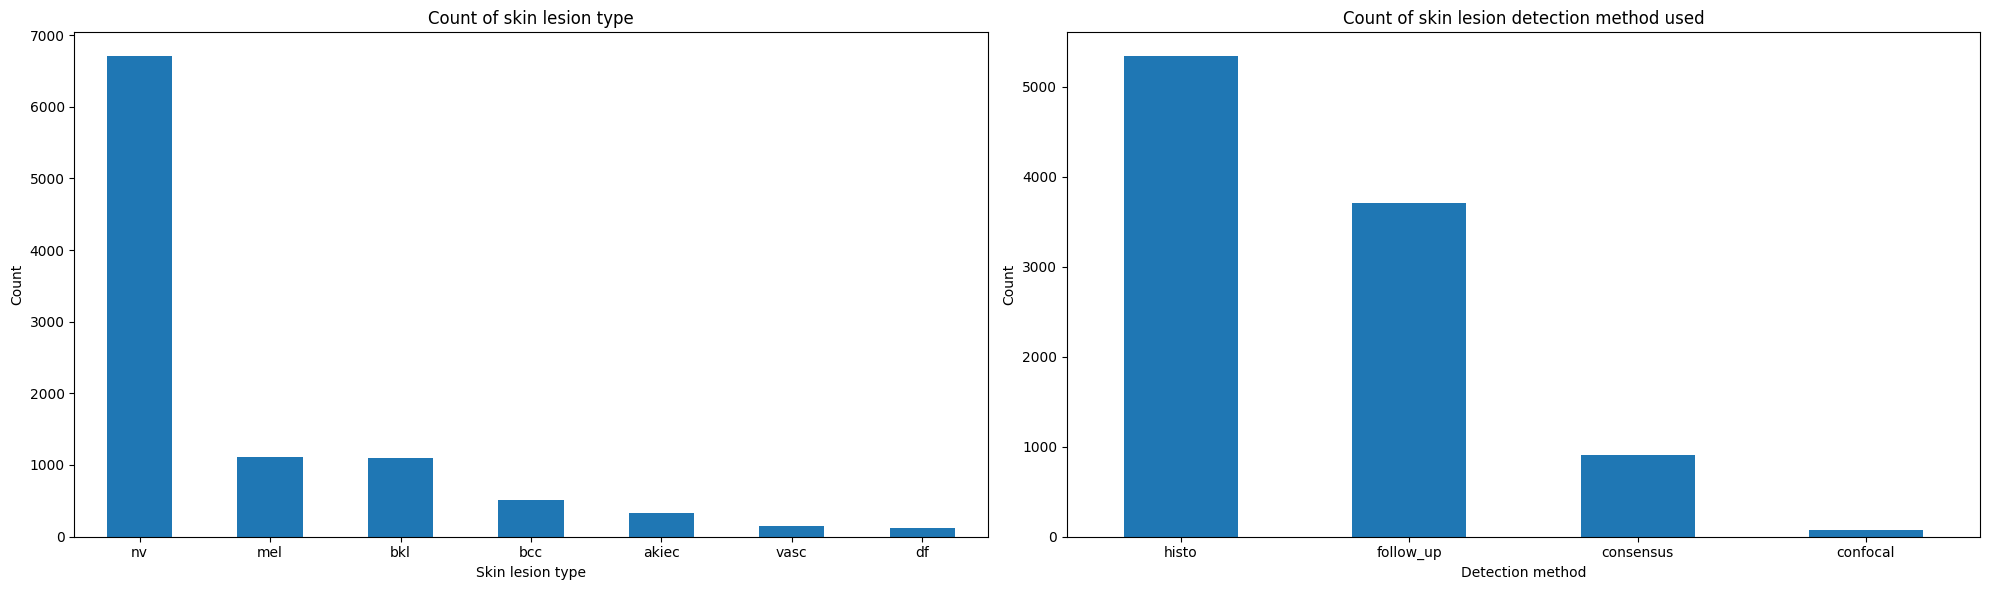

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot for 'dx' column
dx_counts = df['dx'].value_counts()
dx_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Count of skin lesion type')
axes[0].set_xlabel('Skin lesion type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Plot for 'dx_type' column
dx_type_counts = df['dx_type'].value_counts()
dx_type_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Count of skin lesion detection method used')
axes[1].set_xlabel('Detection method')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

The cases taken into consideration comprise a representative collection of all the most important diagnostic categories in the field of pigmented lesions: 
- **Cancerous (Malignant):**
    - Melanoma -> `mel`
    - Basal cell carcinoma -> `bcc`
    - Actinic keratoses and intraepithelial carcinoma / Bowen's disease -> `akiec`
- **Non-Cancerous (Benign):**
    - Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses) -> `bkl` 
    - Melanocytic nevi -> `nv`
    - Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage) -> `vasc`
    - Dermatofibroma -> `df`


More than 50% of lesions are confirmed through histopathology (`histo`), the ground truth for the rest of the cases is either follow-up examination (`follow_up`), expert consensus (`consensus`), or confirmation by in-vivo confocal microscopy (`confocal`).

As we can see there is an high class imbalance where the benign classes were better represented than the malignant ones. To solve this problem we applied some oversampling by doing data augmentation on the minority classes in order to reach the same amount of images for all classes (We will see this in more detail in the following sections).

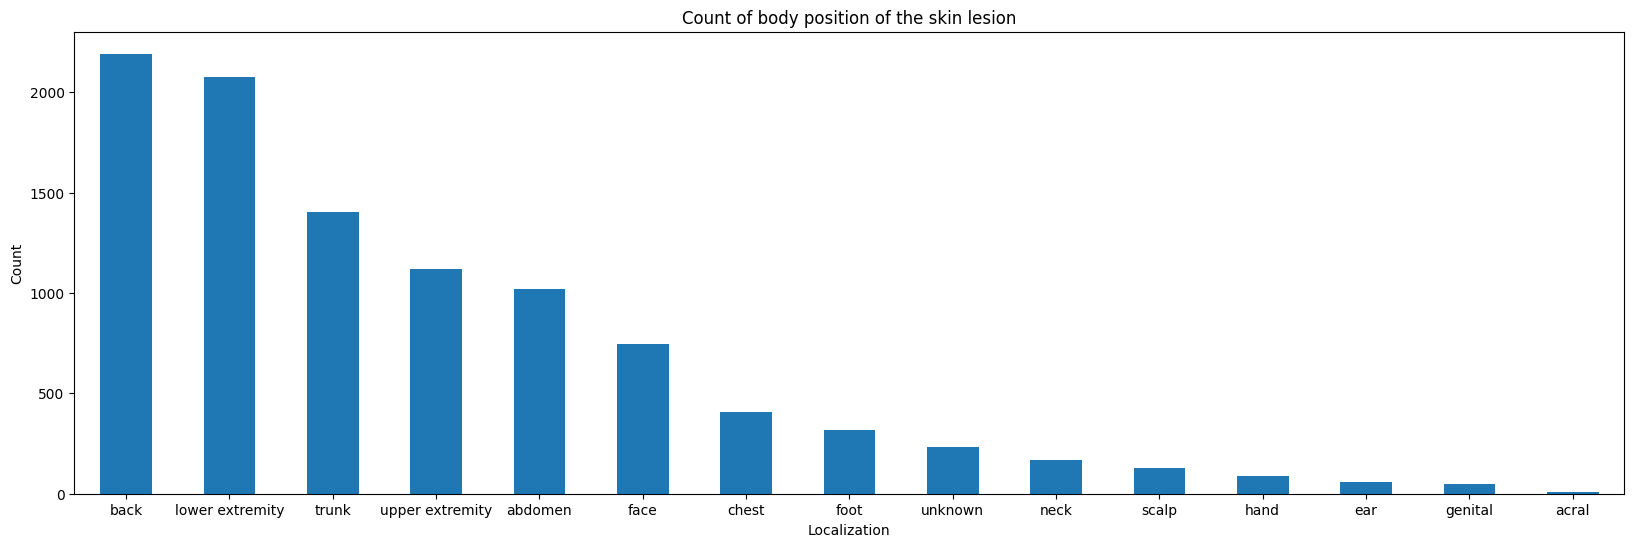

In [7]:
# Get the count of each unique value in the 'dx' column
localization_counts = df['localization'].value_counts()

# Create a bar chart
plt.figure(figsize=(20, 6))
localization_counts.plot(kind='bar')
plt.title('Count of body position of the skin lesion')
plt.xlabel('Localization')
plt.ylabel('Count')

# Set the x-axis labels to display horizontally
plt.xticks(rotation='horizontal')
plt.show()

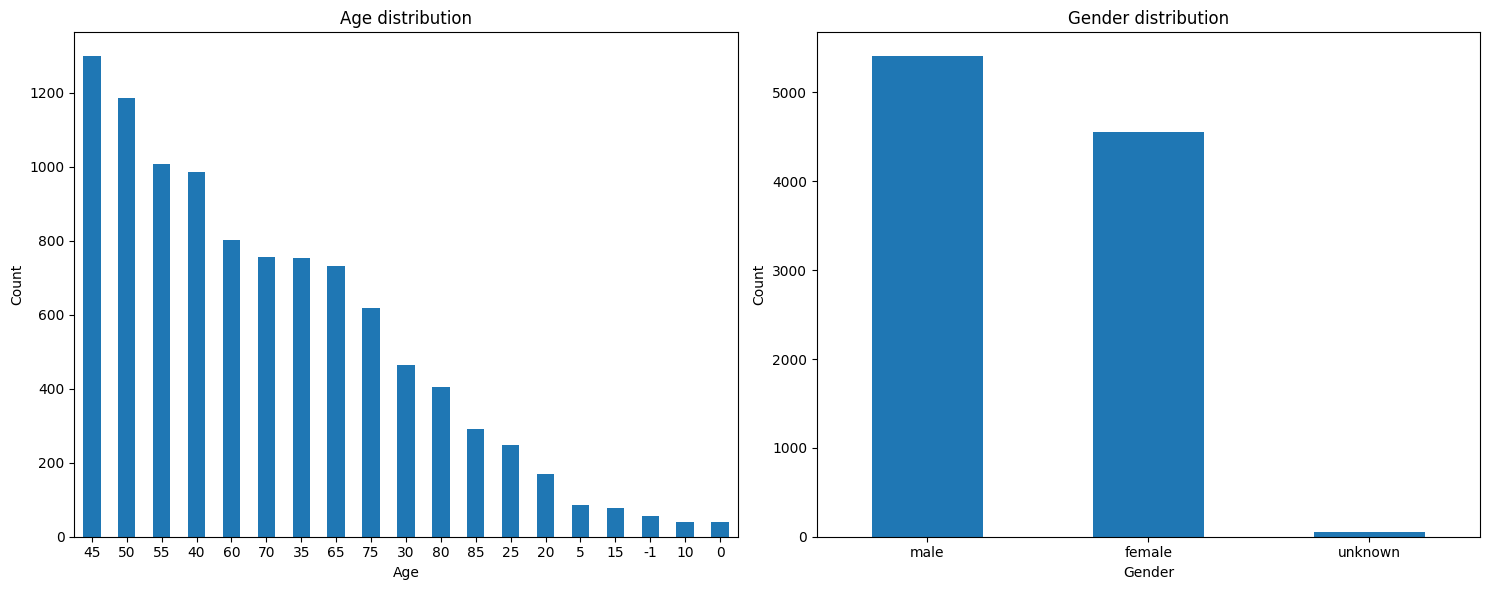

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for 'dx' column
df['age'] = df['age'].fillna(-1).astype(int)
age_counts = df['age'].value_counts()
age_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Age distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Plot for 'dx_type' column
sex_type_counts = df['sex'].value_counts()
sex_type_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Gender distribution')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

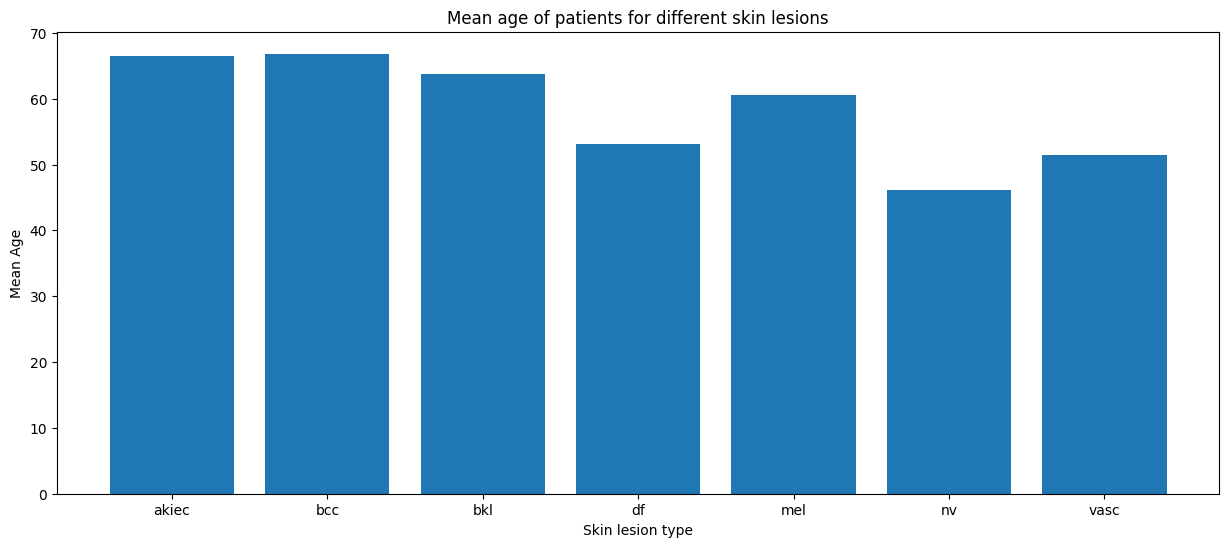

In [9]:
# Calculate the mean age for each skin lesion type
mean_ages = df.groupby('dx')['age'].mean()

# Create a bar plot
plt.figure(figsize=(15, 6))
plt.bar(mean_ages.index, mean_ages.values)

plt.title('Mean age of patients for different skin lesions')
plt.xlabel('Skin lesion type')
plt.ylabel('Mean Age')
plt.show()

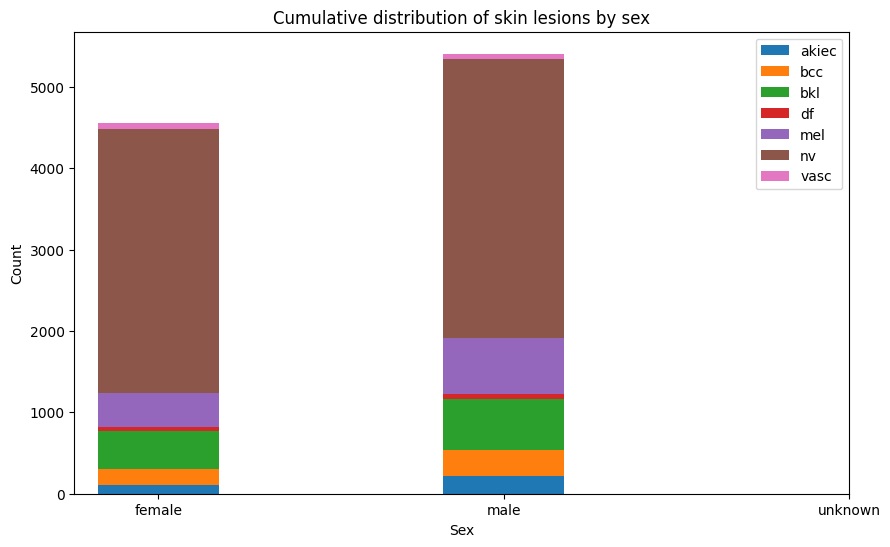

In [10]:
# Calculate the count of each skin lesion type for each sex
lesion_counts = df.groupby(['sex', 'dx']).size().unstack()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width
bar_width = 0.35

# Positions of the left bar-boundaries
bar_l = np.arange(len(lesion_counts.index))

# Create a cumulative bar plot for each skin lesion type
cumulative_values = np.zeros(len(lesion_counts.index))
for dx in lesion_counts.columns:
    values = lesion_counts[dx].values
    ax.bar(bar_l, values, bottom=cumulative_values, width=bar_width, label=dx)
    cumulative_values += values

ax.set_title('Cumulative distribution of skin lesions by sex')
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.set_xticks(bar_l)
ax.set_xticklabels(lesion_counts.index)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

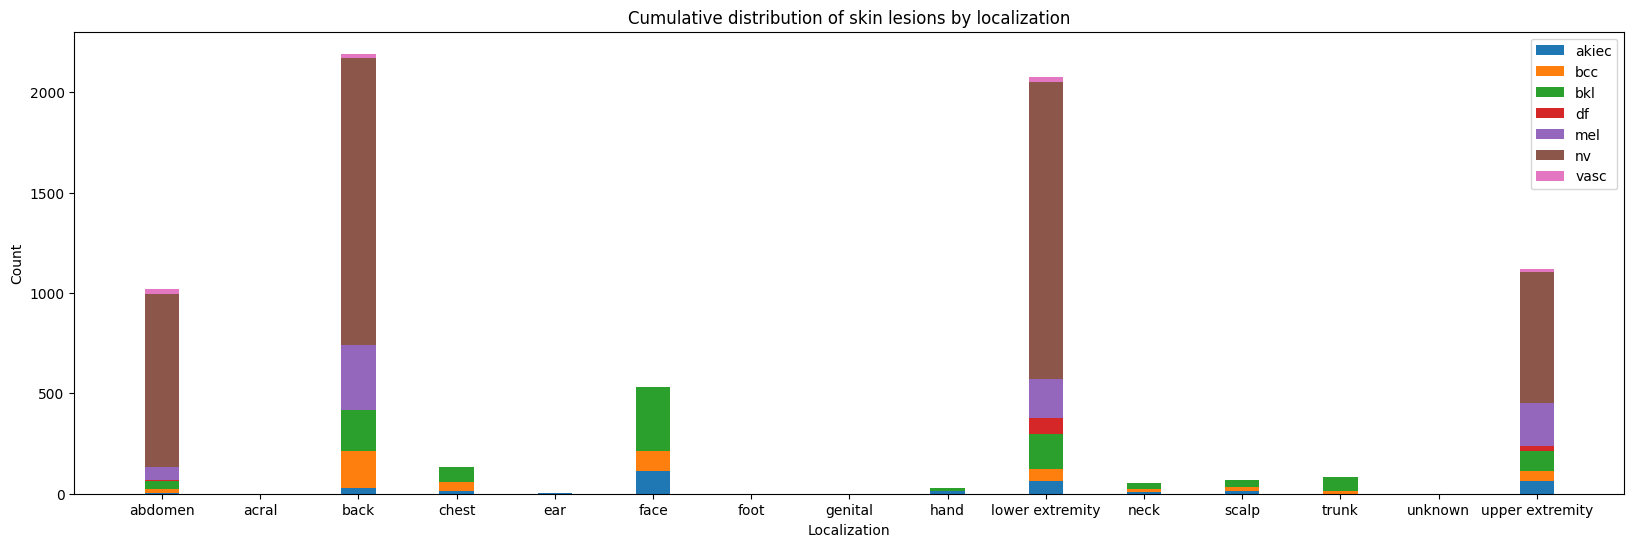

In [11]:
# Calculate the count of each skin lesion type for each localization
lesion_counts = df.groupby(['localization', 'dx']).size().unstack()

# Create a bar plot
fig, ax = plt.subplots(figsize=(20, 6))

# Define bar width
bar_width = 0.35

# Positions of the left bar-boundaries
bar_l = np.arange(len(lesion_counts.index))

# Create a cumulative bar plot for each skin lesion type
cumulative_values = np.zeros(len(lesion_counts.index))
for dx in lesion_counts.columns:
    values = lesion_counts[dx].values
    ax.bar(bar_l, values, bottom=cumulative_values, width=bar_width, label=dx)
    cumulative_values += values

ax.set_title('Cumulative distribution of skin lesions by localization')
ax.set_xlabel('Localization')
ax.set_ylabel('Count')
ax.set_xticks(bar_l)
ax.set_xticklabels(lesion_counts.index)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

## 3.2 Metadata visualization (splitted)

During train / validation / test phase images and metadata will be splitted into train, validation and test set. Here is an example.

In [12]:
strategy = SegmentationStrategy.NO_SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
    strategy=strategy,
    normalize=False,
    batch_size=16,
    normalization_statistics=IMAGENET_STATISTICS,
    oversample_train=False)
train_metadata_no_oversampling = dataloader.get_train_dataloder().dataset.metadata
val_metadata_no_oversampling = dataloader.get_val_dataloader().dataset.metadata
test_metadata_no_oversampling = dataloader.get_test_dataloader().dataset.metadata

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
Using device: cuda
Using device: cuda


In [13]:
metadata_no_oversampling = pd.concat([train_metadata_no_oversampling, val_metadata_no_oversampling, test_metadata_no_oversampling])
metadata_no_oversampling

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_path,segmentation_path,train,augmented
9124,HAM_0004614,ISIC_0030151,nv,histo,65.0,female,upper extremity,rosendahl,0,data\HAM10000_images_train\ISIC_0030151.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,True,False
811,HAM_0002683,ISIC_0031677,bkl,confocal,75.0,male,face,vidir_modern,1,data\HAM10000_images_train\ISIC_0031677.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,True,False
8345,HAM_0001507,ISIC_0029215,nv,histo,35.0,male,abdomen,vienna_dias,0,data\HAM10000_images_train\ISIC_0029215.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,True,False
9932,HAM_0006592,ISIC_0024925,akiec,histo,75.0,male,abdomen,rosendahl,3,data\HAM10000_images_train\ISIC_0024925.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,True,False
4470,HAM_0006500,ISIC_0032479,nv,follow_up,45.0,female,lower extremity,vidir_molemax,0,data\HAM10000_images_train\ISIC_0032479.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,HAM_0005869,ISIC_0029249,bkl,histo,75.0,female,chest,rosendahl,1,data\HAM10000_images_train\ISIC_0029249.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,NaN,False
6211,HAM_0002236,ISIC_0027894,nv,follow_up,45.0,female,abdomen,vidir_molemax,0,data\HAM10000_images_train\ISIC_0027894.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,NaN,False
1935,HAM_0001299,ISIC_0026545,mel,histo,55.0,female,back,vienna_dias,2,data\HAM10000_images_train\ISIC_0026545.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,NaN,False
6401,HAM_0003442,ISIC_0027929,nv,follow_up,45.0,male,back,vidir_molemax,0,data\HAM10000_images_train\ISIC_0027929.jpg,data\HAM10000_segmentations_lesion_tschandl\IS...,NaN,False


The following columns were added:
- `label`: indicates with a number the dx to which it belongs `{'nv': 0, 'blk': 1, 'mel': 2, 'akiec': 3, 'bcc': 4, 'df': 5, 'vasc': 6}`
- `image_path`: path of where the associated image is saved
- `segmentation_path`: path of where the associated segmentation is saved (note: only the images used for training have it)
- `train`: indicates whether the image will be used for the train (true) or not (NaN)
- `augmented`: indicates whether the image will be augmented or not

In [14]:
# Shapes of train dataset
print(train_metadata_no_oversampling.shape)

(7210, 13)


In [15]:
# Shapes of validation dataset
print(val_metadata_no_oversampling.shape)

(1803, 12)


In [16]:
# Shapes of test dataset
print(test_metadata_no_oversampling.shape)

(1002, 12)


## 3.3 Metadata visualization (with oversampling)

Here we can see how by applying oversampling we are able to solve the problem of class imbalance.

In [17]:
strategy = SegmentationStrategy.NO_SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
    strategy=strategy,
    normalize=False,
    batch_size=16,
    normalization_statistics=IMAGENET_STATISTICS,
    oversample_train=True)
train_metadata_with_oversampling = dataloader.get_train_dataloder().dataset.metadata

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 4827 images.
--Data Balance-- The second common class is 2 with 802 images with a difference of 4025 images from the most common class.
--Data Balance (Undersampling)-- Keeping 1448 from 0 class..
--Data Balance (Undersampling)-- 0 now has 1448 images
--Data Balance (Oversampling)-- Adding 657 from 1 class..
--Data Balance (Oversampling)-- Adding 1213 from 3 class..
--Data Balance (Oversampling)-- Adding 646 from 2 class..
--Data Balance (Oversampling)-- Adding 1078 from 4 class..
--Data Balance (Oversampling)-- Adding 1365 from 5 class..
--Data Balance (Oversampling)-- Adding 1346 from 6 class..


In [18]:
# Shapes of train dataset
print(f'Train metadata (before oversampling): {train_metadata_no_oversampling.shape}')
print(f'Train metadata (after oversampling): {train_metadata_with_oversampling.shape}')

Train metadata (before oversampling): (7210, 13)
Train metadata (after oversampling): (10136, 13)


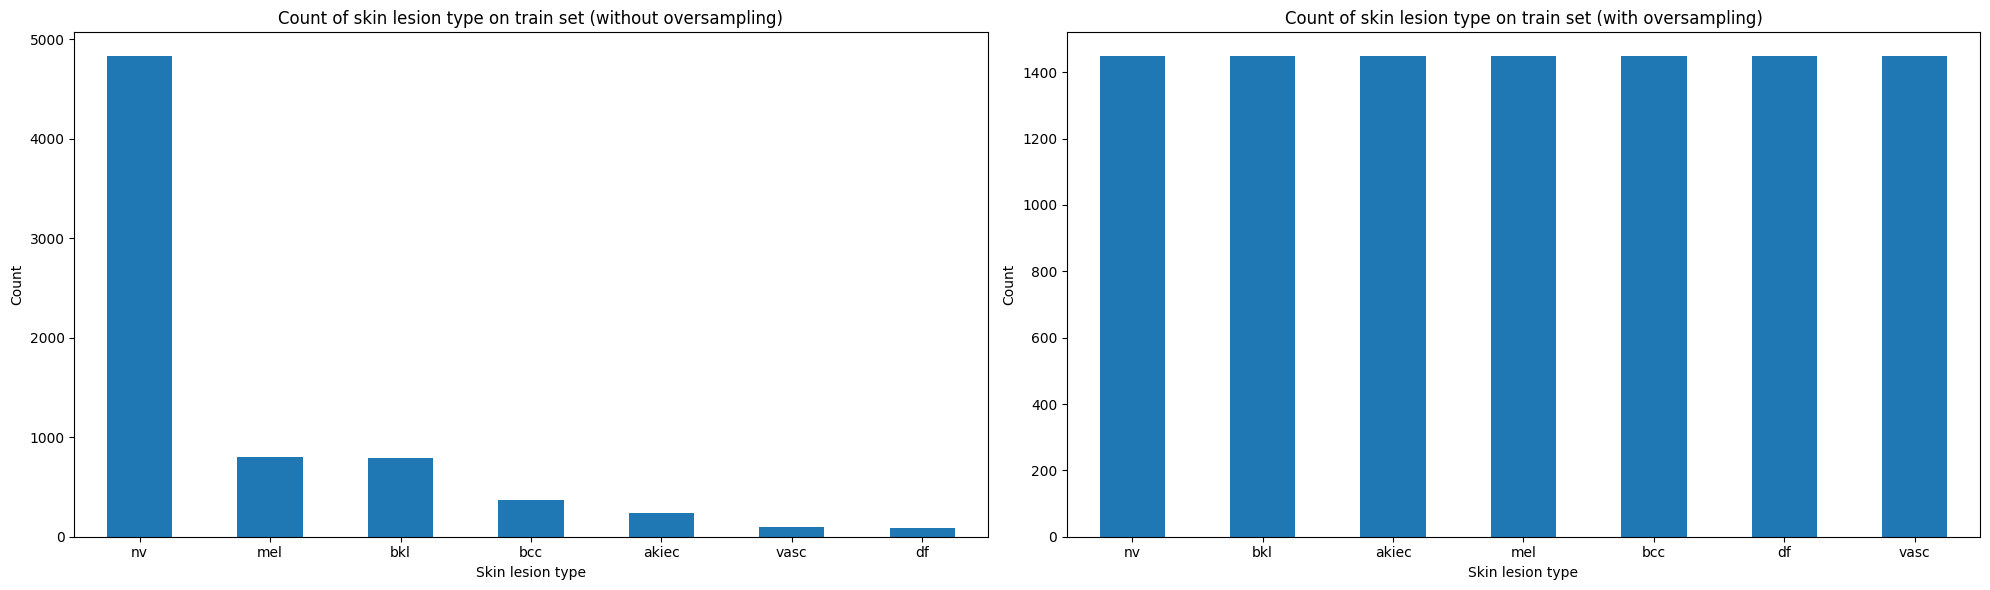

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

dx_counts = train_metadata_no_oversampling['dx'].value_counts()
dx_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Count of skin lesion type on train set (without oversampling)')
axes[0].set_xlabel('Skin lesion type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

dx_counts = train_metadata_with_oversampling['dx'].value_counts()
dx_counts.plot(kind='bar', ax=axes[1])
axes[1].set_title('Count of skin lesion type on train set (with oversampling)')
axes[1].set_xlabel('Skin lesion type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 3.4 Images visualization

This section will show some examples of the images contained in the dataset and the type of segmentation that will be applied during our tests.

### 3.4.1 With background

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 4827 images.
--Data Balance-- The second common class is 2 with 802 images with a difference of 4025 images from the most common class.
--Data Balance (Undersampling)-- Keeping 1448 from 0 class..
--Data Balance (Undersampling)-- 0 now has 1448 images
--Data Balance (Oversampling)-- Adding 657 from 1 class..
--Data Balance (Oversampling)-- Adding 1213 from 3 class..
--Data Balance (Oversampling)-- Adding 646 from 2 class..
--Data Balance (Oversampling)-- Adding 1078 from 4 class..
--Data Balance (Oversampling)-- Adding 1365 from 5 class..
--Data Balance (Oversampling)-- Adding 1346 from 6 class..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


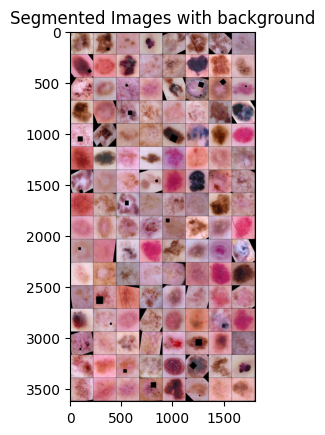

In [20]:
strategy = SegmentationStrategy.SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
        strategy=strategy,
        normalize=False,
        keep_background=True)
train_dataloader = dataloader.get_train_dataloder()
batch = next(iter(train_dataloader))
images, labels = batch
plot_image_grid(images, "Segmented Images with background")


### 3.4.2 Without Background

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 4827 images.
--Data Balance-- The second common class is 2 with 802 images with a difference of 4025 images from the most common class.
--Data Balance (Undersampling)-- Keeping 1448 from 0 class..
--Data Balance (Undersampling)-- 0 now has 1448 images
--Data Balance (Oversampling)-- Adding 657 from 1 class..
--Data Balance (Oversampling)-- Adding 1213 from 3 class..
--Data Balance (Oversampling)-- Adding 646 from 2 class..
--Data Balance (Oversampling)-- Adding 1078 from 4 class..
--Data Balance (Oversampling)-- Adding 1365 from 5 class..
--Data Balance (Oversampling)-- Adding 1346 from 6 class..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


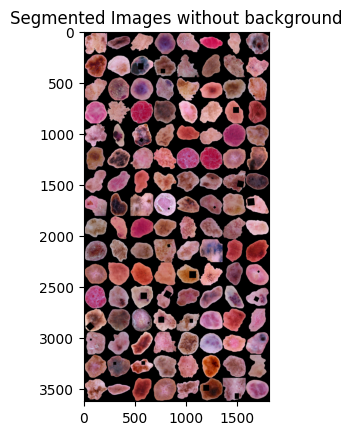

In [21]:
strategy = SegmentationStrategy.SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
    strategy=strategy,
    normalize=False,
    keep_background=False)
train_dataloader = dataloader.get_train_dataloder()
batch = next(iter(train_dataloader))
images, labels = batch
plot_image_grid(images, "Segmented Images without background")

### 3.4.3 No segmentation

In this case, images are segmented with the ground truth provided.

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 4827 images.
--Data Balance-- The second common class is 2 with 802 images with a difference of 4025 images from the most common class.
--Data Balance (Undersampling)-- Keeping 1448 from 0 class..
--Data Balance (Undersampling)-- 0 now has 1448 images
--Data Balance (Oversampling)-- Adding 657 from 1 class..
--Data Balance (Oversampling)-- Adding 1213 from 3 class..
--Data Balance (Oversampling)-- Adding 646 from 2 class..
--Data Balance (Oversampling)-- Adding 1078 from 4 class..
--Data Balance (Oversampling)-- Adding 1365 from 5 class..
--Data Balance (Oversampling)-- Adding 1346 from 6 class..


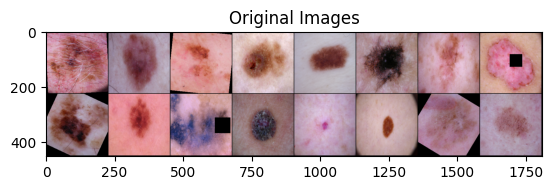

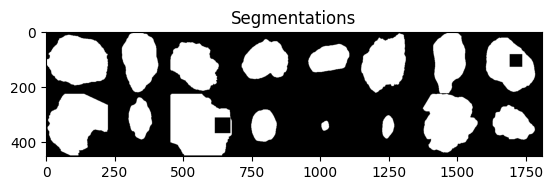

Using device: cuda


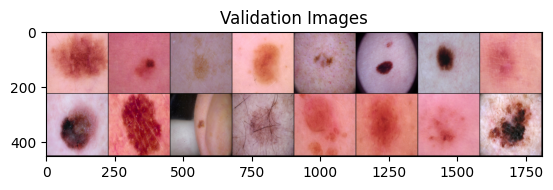

In [22]:
strategy = SegmentationStrategy.NO_SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
    strategy=strategy,
    normalize=False,
    batch_size=16,
    normalization_statistics=IMAGENET_STATISTICS)
train_dataloader = dataloader.get_train_dataloder()
batch = next(iter(train_dataloader))
images, labels, segmentations = batch
plot_image_grid(images, "Original Images")
plot_image_grid(segmentations, "Segmentations")
val_dataloader = dataloader.get_val_dataloader()
batch = next(iter(val_dataloader))
images, labels = batch
plot_image_grid(images, "Validation Images")

### 3.4.4 Dynamic segmentation

In this case, images are segmented with the ground truth and the validation / test images are segmented at the fly with a strategy using the Segment Anything Model (SAM).

**With background**

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 4827 images.
--Data Balance-- The second common class is 2 with 802 images with a difference of 4025 images from the most common class.
--Data Balance (Undersampling)-- Keeping 1448 from 0 class..
--Data Balance (Undersampling)-- 0 now has 1448 images
--Data Balance (Oversampling)-- Adding 657 from 1 class..
--Data Balance (Oversampling)-- Adding 1213 from 3 class..
--Data Balance (Oversampling)-- Adding 646 from 2 class..
--Data Balance (Oversampling)-- Adding 1078 from 4 class..
--Data Balance (Oversampling)-- Adding 1365 from 5 class..
--Data Balance (Oversampling)-- Adding 1346 from 6 class..


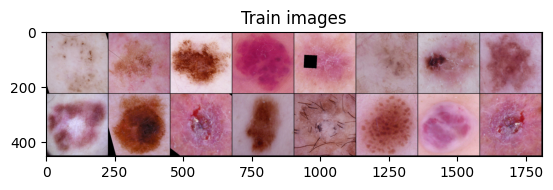

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Min and max of validation images -0.00825647171586752 1.0


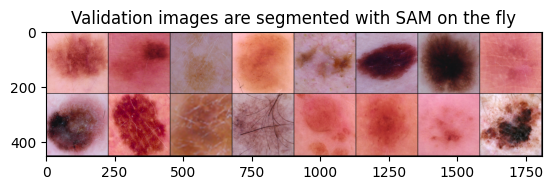

Using device: cuda


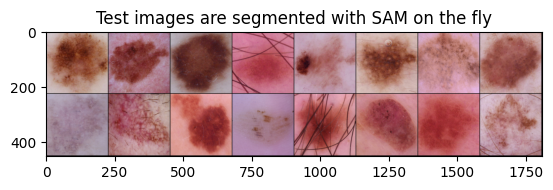

In [23]:
strategy = SegmentationStrategy.DYNAMIC_SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
    strategy=strategy,
    dynamic_segmentation_strategy=DynamicSegmentationStrategy.SAM.value,
    normalize=False,
    batch_size=16,
    normalization_statistics=IMAGENET_STATISTICS,
    keep_background=True,)
train_dataloader = dataloader.get_train_dataloder()
batch = next(iter(train_dataloader))
images, labels = batch
plot_image_grid(images, "Train images") 
val_dataloader = dataloader.get_val_dataloader()
batch = next(iter(val_dataloader))
images, labels = batch
print(f"Min and max of validation images {images.min()} {images.max()}")
plot_image_grid(images, "Validation images are segmented with SAM on the fly")
test_dataloader = dataloader.get_test_dataloader()
batch = next(iter(test_dataloader))
images, labels = batch
plot_image_grid(images, "Test images are segmented with SAM on the fly")

**Without background**

Using device: cuda
LOADED METADATA HAS LENGTH 10015
---TRAIN---: 7210 entries
---VAL---: 1803 entries
---TEST---: 1002 entries
Using device: cuda
--Data Balance-- balance_data set to True. Training data will be balanced.
--Data Balance-- The most common class is 0 with 4827 images.
--Data Balance-- The second common class is 2 with 802 images with a difference of 4025 images from the most common class.
--Data Balance (Undersampling)-- Keeping 1448 from 0 class..
--Data Balance (Undersampling)-- 0 now has 1448 images
--Data Balance (Oversampling)-- Adding 657 from 1 class..
--Data Balance (Oversampling)-- Adding 1213 from 3 class..
--Data Balance (Oversampling)-- Adding 646 from 2 class..
--Data Balance (Oversampling)-- Adding 1078 from 4 class..
--Data Balance (Oversampling)-- Adding 1365 from 5 class..
--Data Balance (Oversampling)-- Adding 1346 from 6 class..


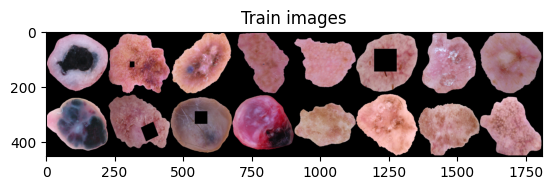

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Min and max of validation images -0.20311778783798218 1.176761507987976


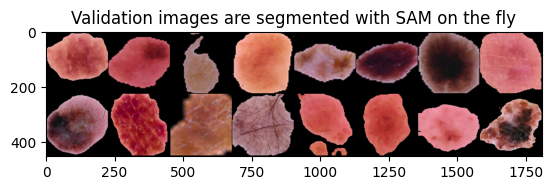

Using device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


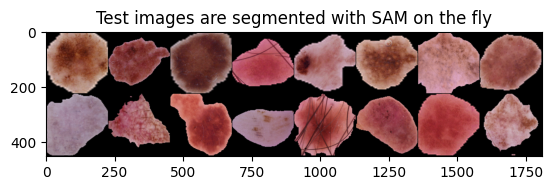

In [24]:
strategy = SegmentationStrategy.DYNAMIC_SEGMENTATION.value
dataloader = get_dataloder_from_strategy(
    strategy=strategy,
    dynamic_segmentation_strategy=DynamicSegmentationStrategy.SAM.value,
    normalize=False,
    batch_size=16,
    normalization_statistics=IMAGENET_STATISTICS,
    keep_background=False,)
train_dataloader = dataloader.get_train_dataloder()
batch = next(iter(train_dataloader))
images, labels = batch
plot_image_grid(images, "Train images") 
val_dataloader = dataloader.get_val_dataloader()
batch = next(iter(val_dataloader))
images, labels = batch
print(f"Min and max of validation images {images.min()} {images.max()}")
plot_image_grid(images, "Validation images are segmented with SAM on the fly")
test_dataloader = dataloader.get_test_dataloader()
batch = next(iter(test_dataloader))
images, labels = batch
plot_image_grid(images, "Test images are segmented with SAM on the fly")